In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchvision import datasets, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import TrainerVTS_V07D1 as TP
import DataSetting_v2 as DS
from tqdm.notebook import tqdm

### Loader

In [2]:
gpu = 6
date = '240512'
#run = ['30', '100', '300', '900']
run= '900'

In [4]:
#for ru in run:
datadir = f'../dataset/0509/make19_{run}'
dataplanner = DS.DataPlanner(datadir)
dataplanner.load_raw()
train_data = dataplanner.regroup({'T01', 'T02', 'T03', 'T04'})
test_data = dataplanner.regroup({'T01'})
train_dataset = DS.MyDataset('tv', train_data)
test_dataset = DS.MyDataset('test', test_data)
train_loader, valid_loader = DS.DataSplitter(train_dataset, distributed=False, gpu=gpu).split_loader()
test_loader = DS.DataSplitter(test_dataset, 1, distributed=False).gen_loader()

Loading dataset...


  0%|          | 0/1210 [00:00<?, ?it/s]

Excluded T01_G00_S00_cimg len 0
Excluded T01_G00_S06_csi len 0
Excluded T01_G04_S04_time len 0
Excluded T01_G04_S05_center len 0
Excluded T01_G04_S06_time len 0
Excluded T01_G04_S00_rimg len 0
Excluded T01_G04_S03_rimg len 0
Excluded T01_G04_S02_rimg len 0
Excluded T01_G04_S08_cimg len 0


  0%|          | 0/2 [00:00<?, ?it/s]

Regrouping...


  0%|          | 0/10 [00:00<?, ?it/s]

T04 tag len=21 
T03 tag len=57 
T01 tag len=96 
T02 tag len=125 
Done
T04 depth len=21 
T03 depth len=57 
T01 depth len=96 
T02 depth len=125 
Done
T04 csi len=21 
T03 csi len=57 
T01 csi len=96 
T02 csi len=125 
Done
T04 center len=21 
T03 center len=57 
T01 center len=96 
T02 center len=125 
Done
T04 pd len=21 
T03 pd len=57 
T01 pd len=96 
T02 pd len=125 
Done
T04 cimg len=21 
T03 cimg len=57 
T01 cimg len=96 
T02 cimg len=125 
Done
T04 bbx len=21 
T03 bbx len=57 
T01 bbx len=96 
T02 bbx len=125 
Done
T04 time len=21 
T03 time len=57 
T01 time len=96 
T02 time len=125 
Done
T04 ind len=21 
T03 ind len=57 
T01 ind len=96 
T02 ind len=125 
Done
T04 rimg len=21 
T03 rimg len=57 
T01 rimg len=96 
T02 rimg len=125 
Done
Regrouping...


  0%|          | 0/10 [00:00<?, ?it/s]

T01 tag len=39 
Done
T01 depth len=39 
Done
T01 csi len=39 
Done
T01 center len=39 
Done
T01 pd len=39 
Done
T01 cimg len=39 
Done
T01 bbx len=39 
Done
T01 time len=39 
Done
T01 ind len=39 
Done
T01 rimg len=39 
Done
Generating loaders...
 tv len 7114 distributed=False
 exported train loader of len 88, batch size 64
 exported valid loader of len 22, batch size 64

Generating loaders...
 test len 1229
 exported loader of len 1229, batch size 1


In [ ]:
for mod, value in train_data.items():
    np.save(f'{datadir}-finished/{mod}', value)

### Teacher

In [4]:
imgencoder = TP.ImageEncoder(latent_dim=16)
imgdecoder = TP.ImageDecoder(latent_dim=16)

T_trainer = TP.TeacherTrainer(beta=0.5, 
                              mask=True,
                              recon_lossfunc=nn.MSELoss(reduction='sum'),
                              name='Teacher', networks=[imgencoder, imgdecoder],
                 lr=1e-4, epochs=10, cuda=gpu,
                 train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader,
                             notion=f"{date}_{run}D")

In [5]:
### Scheduler
%matplotlib inline
T_trained = T_trainer.train(autosave=True, notion=f"{date}_{run}D")
T_trainer.plot_train_loss(autosave=True, notion=f"{date}_{run}D")

Teacher train: epoch=1/999, batch=0/68, loss=4301.1064, current best valid loss=inf    
Teacher train: epoch=1/999, batch=5/68, loss=4215.6924, current best valid loss=inf    
Teacher train: epoch=1/999, batch=10/68, loss=3805.9316, current best valid loss=inf    
Teacher train: epoch=1/999, batch=15/68, loss=2524.9778, current best valid loss=inf    
Teacher train: epoch=1/999, batch=20/68, loss=2335.6296, current best valid loss=inf    
Teacher train: epoch=1/999, batch=25/68, loss=2484.6262, current best valid loss=inf    
Teacher train: epoch=1/999, batch=30/68, loss=2431.0427, current best valid loss=inf    
Teacher train: epoch=1/999, batch=35/68, loss=1783.0000, current best valid loss=inf    
Teacher train: epoch=1/999, batch=40/68, loss=1551.7913, current best valid loss=inf    
Teacher train: epoch=1/999, batch=45/68, loss=1244.5990, current best valid loss=inf    
Teacher train: epoch=1/999, batch=50/68, loss=1103.0485, current best valid loss=inf    
Teacher train: epoch=1/

In [17]:
print(T_trainer.loss.loss['pred']['TAG'])

[]


<Figure size 432x288 with 0 Axes>

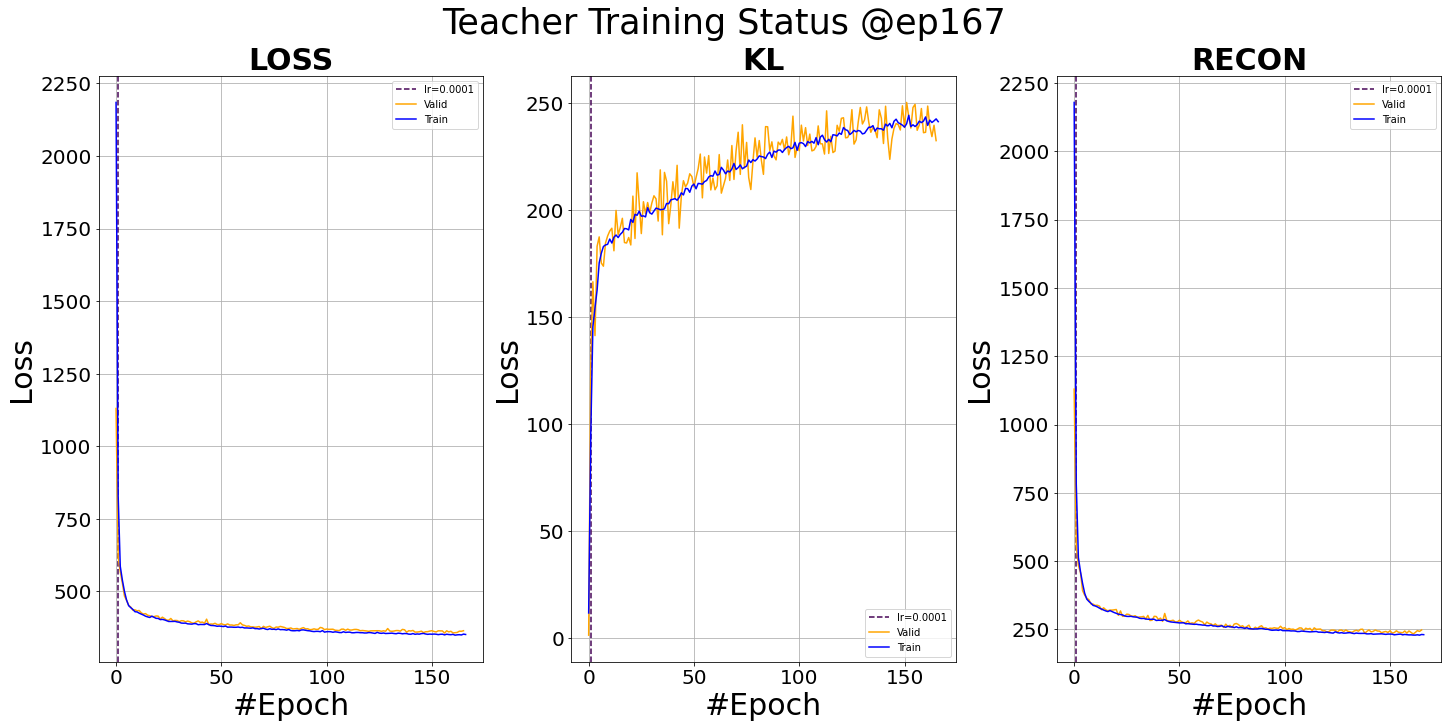

In [6]:
T_trainer.plot_train_loss(autosave=True, notion=f"{date}_{run}D")

Teacher test: sample=0/68, loss=217.3072    
Teacher test: sample=5/68, loss=275.9655    
Teacher test: sample=10/68, loss=199.9587    
Teacher test: sample=15/68, loss=500.8076    
Teacher test: sample=20/68, loss=280.0791    
Teacher test: sample=25/68, loss=245.7940    
Teacher test: sample=30/68, loss=142.0086    
Teacher test: sample=35/68, loss=622.7900    
Teacher test: sample=40/68, loss=191.5119    
Teacher test: sample=45/68, loss=174.1074    
Teacher test: sample=50/68, loss=266.8230    
Teacher test: sample=55/68, loss=341.4221    
Teacher test: sample=60/68, loss=322.2378    
Teacher test: sample=65/68, loss=197.4067    

Test finished. Average loss={'LOSS': 232.9501932754236, 'KL': 3.7107932696612003, 'RECON': 231.09479654185913}

Total training time: 43.163660287857056 sec


<Figure size 1440x720 with 0 Axes>

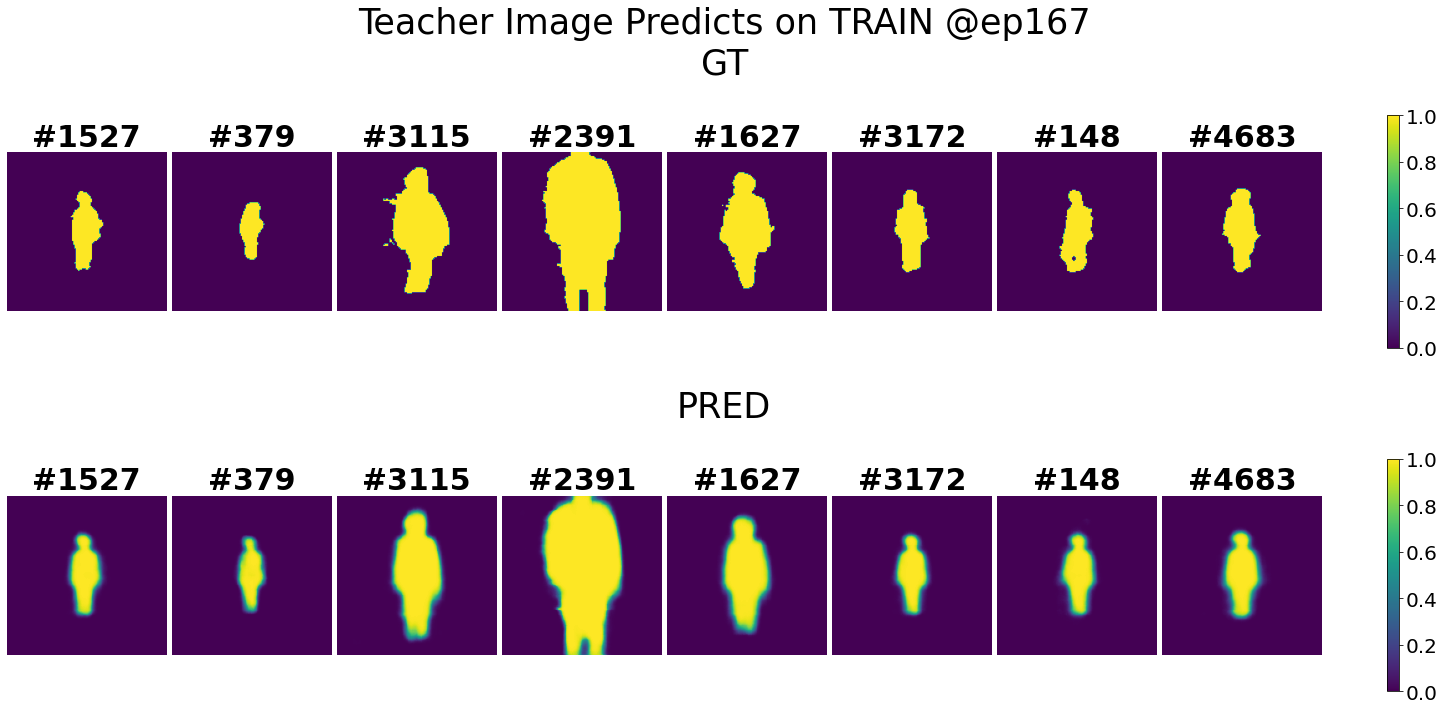

<Figure size 1440x720 with 0 Axes>

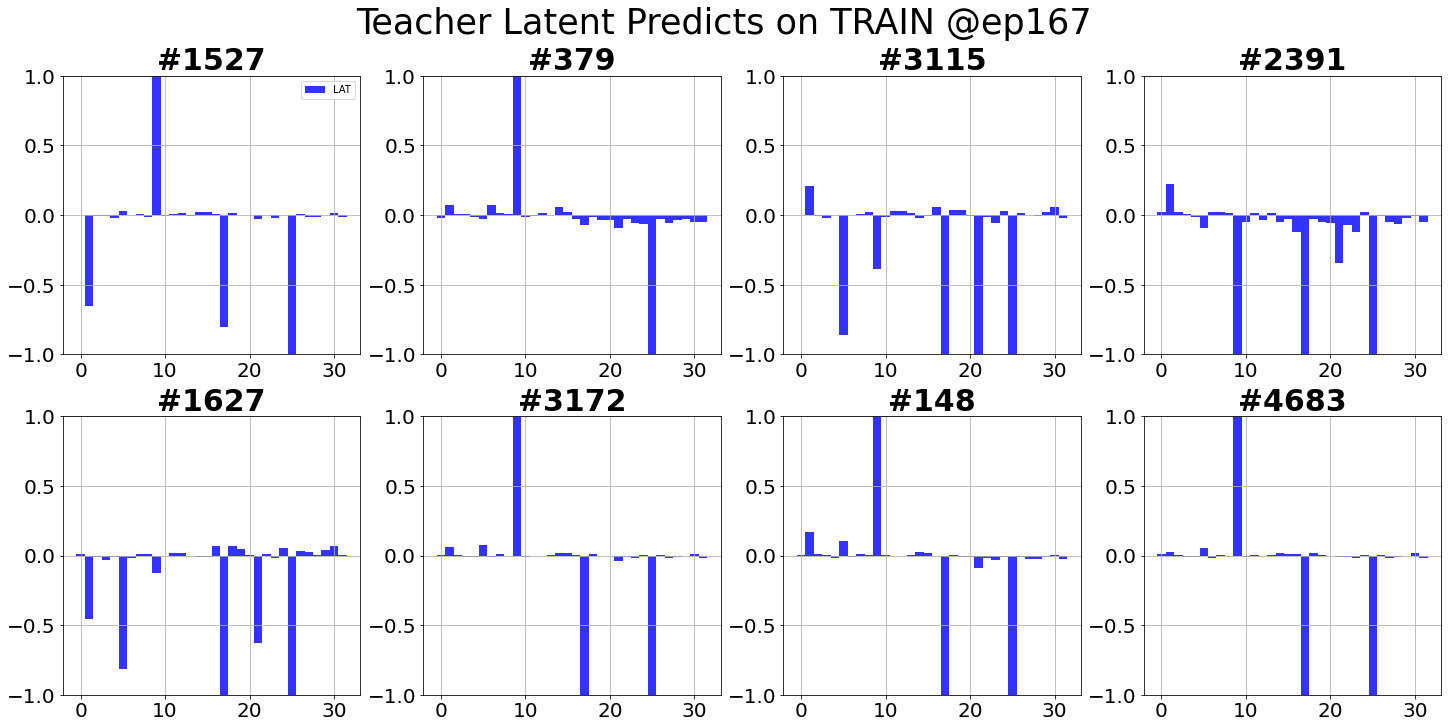

In [ ]:
T_trainer.test(loader='train')
T_trainer.plot_test(select_num=8, autosave=True, notion=f"{date}_{run}D")

Teacher test: sample=0/5069, loss=954.5443    
Teacher test: sample=5/5069, loss=390.1396    
Teacher test: sample=10/5069, loss=252.0587    
Teacher test: sample=15/5069, loss=468.3465    
Teacher test: sample=20/5069, loss=252.0980    
Teacher test: sample=25/5069, loss=541.1893    
Teacher test: sample=30/5069, loss=700.0750    
Teacher test: sample=35/5069, loss=533.2227    
Teacher test: sample=40/5069, loss=633.0488    
Teacher test: sample=45/5069, loss=1364.0687    
Teacher test: sample=50/5069, loss=244.7679    
Teacher test: sample=55/5069, loss=468.8226    
Teacher test: sample=60/5069, loss=461.4322    
Teacher test: sample=65/5069, loss=261.5333    
Teacher test: sample=70/5069, loss=884.5466    
Teacher test: sample=75/5069, loss=298.1056    
Teacher test: sample=80/5069, loss=208.2919    
Teacher test: sample=85/5069, loss=1752.8416    
Teacher test: sample=90/5069, loss=714.7161    
Teacher test: sample=95/5069, loss=305.3376    
Teacher test: sample=100/5069, loss=495.

<Figure size 1440x720 with 0 Axes>

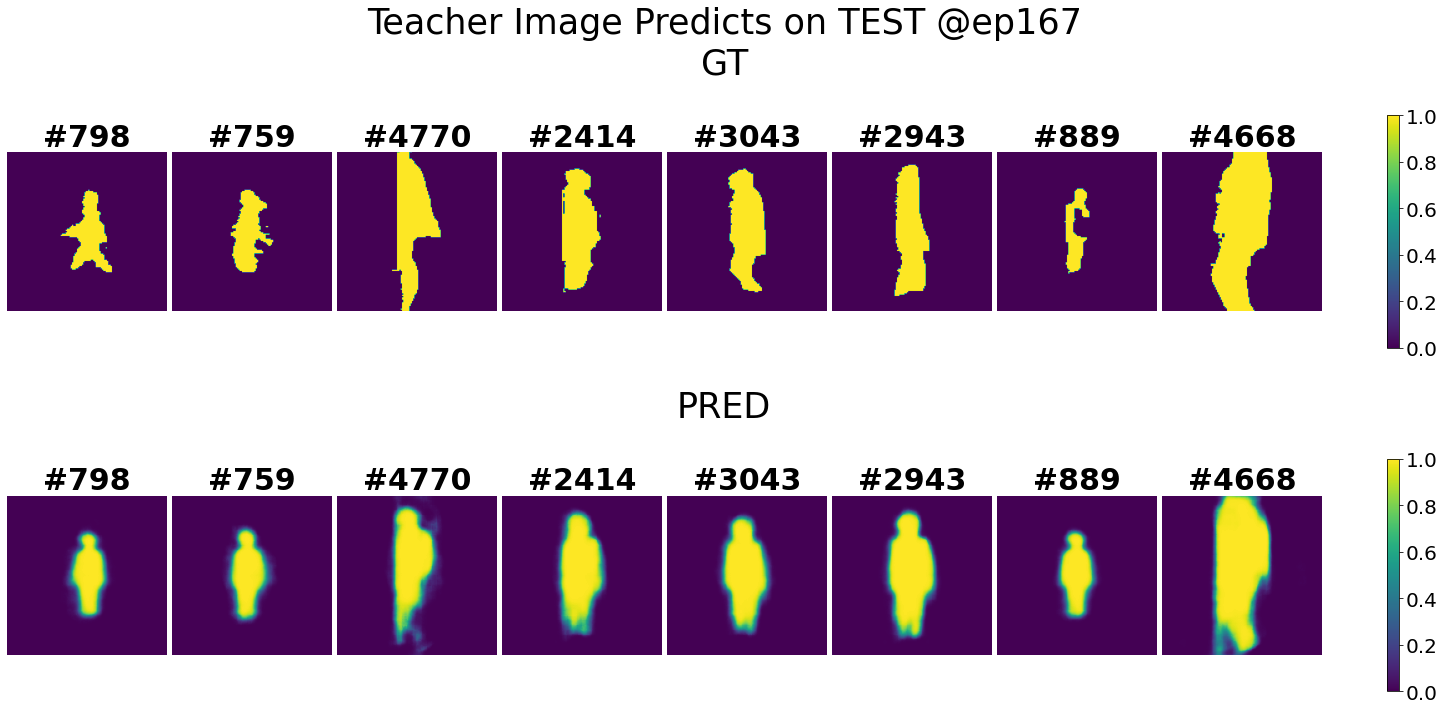

<Figure size 1440x720 with 0 Axes>

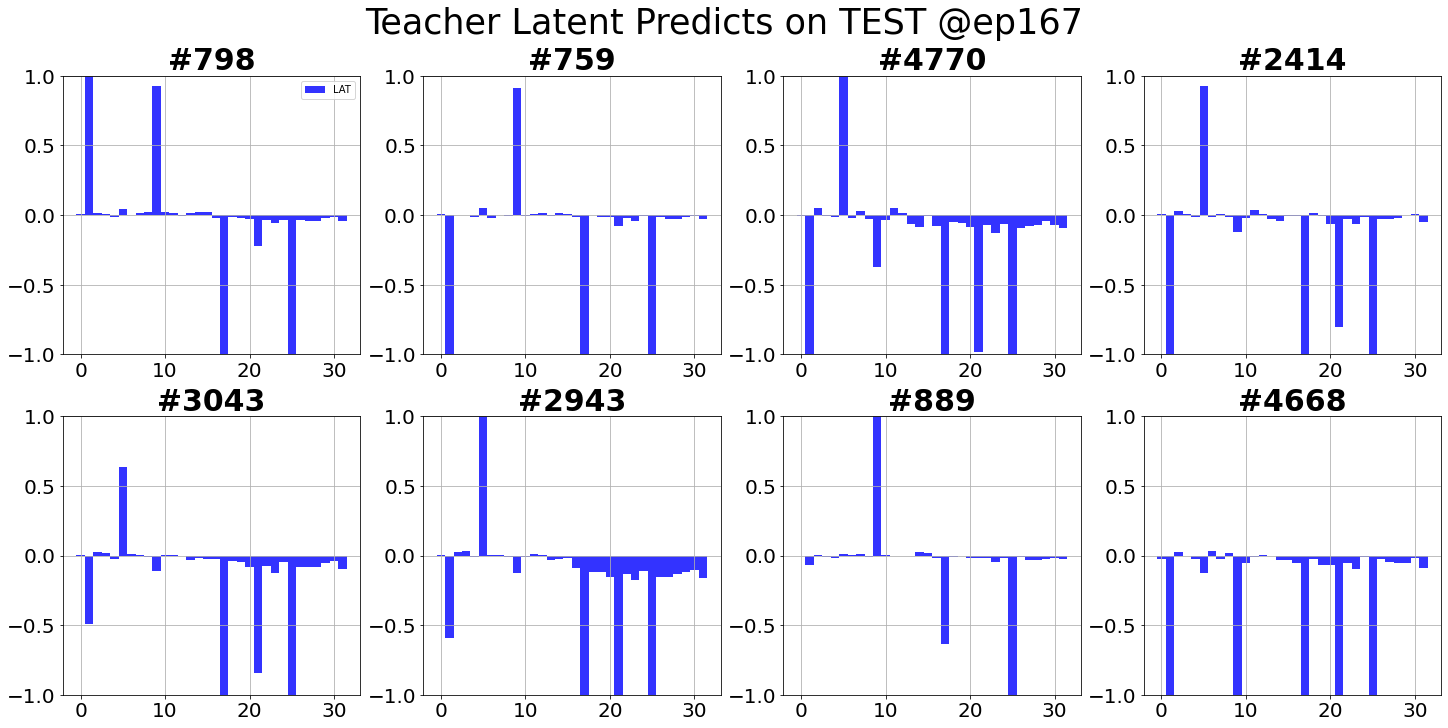

In [20]:
T_trainer.test(loader='test')
T_trainer.plot_test(select_num=8, autosave=True, notion=f"{date}_{run}D")

### Student

#### Train

In [6]:
csiencoder = TP.CSIEncoder(lstm_steps=225)
bbxdecoder = TP.BBXDecoder()
imgencoder = TP.ImageEncoder(latent_dim=16)
imgdecoder = TP.ImageDecoder(latent_dim=16)
imgencoder.load_state_dict(torch.load(f"../saved/240512_30D/240512_30_Teacher_IMGENV07D1@ep167.pth"))
imgdecoder.load_state_dict(torch.load(f"../saved/240512_30D/240512_30_Teacher_IMGDEV07D1@ep167.pth"))
#imgencoder = T_trained['imgen']
#imgdecoder = T_trained['imgde']

S_trainer = TP.StudentTrainer(name='Student', mask=True,
                              networks=[csiencoder, bbxdecoder, imgencoder, imgdecoder],
                              lr=1e-4, epochs=10, cuda=gpu,
                              notion=f"{date}_{run}D",
                              train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader)

In [7]:
# Training and Testing
%matplotlib inline
S_trained = S_trainer.schedule(train_module={'csien', 'bbxde'}, eval_module={'imgen', 'imgde'})

Student train: epoch=1/999, batch=0/44, loss=72.6151, current best valid loss=inf    


OutOfMemoryError: CUDA out of memory. Tried to allocate 758.00 MiB (GPU 5; 11.93 GiB total capacity; 7.80 GiB already allocated; 206.69 MiB free; 9.84 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF